# 1. Importação das bibliotecas necessárias:

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np     
from numpy import average, power, absolute, mean, std

import pandas as pd

from scipy.signal import butter
from scipy.stats import linregress
from scipy import signal

import biosignalsnotebooks as bsnb

# 2.  Informação dos parâmetros de aquisição de sinal:

Nesse trecho, foram atribuídos parâmetros da aquisição de sinais. Nele foram imputadas informações como a idade e gênero da cobaia, qual dispositivo foi utilizado, gestos executados, que tipos de valores são mostrados, assim também como a taxa de atualização do sinal e sua resolução em bits.

In [2]:
info = """# Subject, Age: 30, Gender: M
# Devices: ["20:18:06:13:03:69"]
# Gesture: ["rest", "thunb_up", "extension_index_and_middle", "closed_hand"]
# Label: ["class", "repetition", "EMG_A1"]
# Sampling rate: 1000
# Resolution: [4, 4, 10]
 \n"""

# 3. Definição das funções:

In [3]:
# Função que anexa a informação (citada acima) em um arquivo de texto.

def anexador_texto (arquivo, texto):
    
    with open(arquivo, 'r+') as arq:
        
        conteudo = arq.read()
        arq.seek(0, 0)
        arq.write(texto.rstrip('\r\n') + '\n' + conteudo)

In [4]:
# Função que define faz a "rotulação" do sinal.

def rotulo_sinal (sinal):
    
    sinal_rotulado = []    
    valor = 1
    exerc = 0
    
    for i in range(len(sinal)):
        
        if sinal[i-1]== 0 and sinal[i] == 1:
            
            exerc += 1
                        
            if exerc > 6:
                
                exerc = 1
                valor += 1
                            
            sinal_rotulado.append(valor)
            
        elif sinal[i] == 1:
            
            sinal_rotulado.append(valor)
            
        else:
            
            sinal_rotulado.append(0)
        
    return sinal_rotulado

In [5]:
# Função que "mapeia" os números de repetições em cada exercícios.

def repete_sinal (sinal):
    
    sinal_repetido = []    
    repeticao = 1
    flag=False
    
    for i in range(len(sinal)):          
                    
        if sinal[i-1]== 0 and sinal[i] == 1 and flag==True:
            
            repeticao += 1
                        
            if repeticao > 6:
                
                repeticao = 1                            
            
        elif sinal[i-1]== 1 and sinal[i] == 0 and flag==False:
            
            flag = True  
        
        sinal_repetido.append(repeticao)

    return sinal_repetido

# 4. Execução

## 4.1.1 Sinal adquirido total:

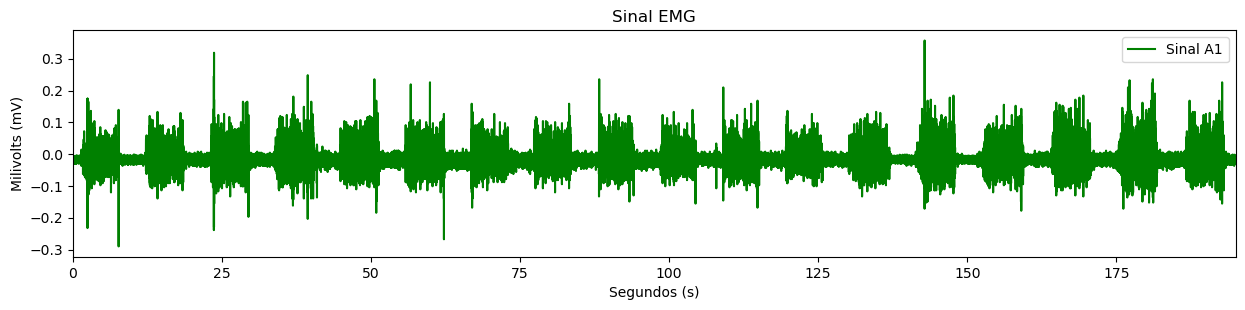

In [6]:
# Definição dos intervalos de alcance dos valores ADC e mV.
alcance_ADC = [0, 1023] 
alcance_mV = [-1.64, 1.64] 


# Importação do sinal em .txt 
ENTRADA = np.loadtxt('3exercicios_v6.txt')   
emg_ADC = ENTRADA


# Calcula coeficientes de conversão ADC para voltagem.
a = alcance_mV[1]-alcance_mV[0]
b = alcance_ADC[1]
c = alcance_mV[0]


# Converte o sinal ADC para mV.
emg_mV = a * emg_ADC / b + c


# Plota sinal EMG para inspeção visual do canal configurado.
INICIO = 0
FIM  = 195

figure(figsize = (15, 3), dpi = 100)
t = np.linspace(INICIO, FIM, len(emg_mV[:,5]))

plt.xlim(INICIO, FIM)
plt.plot(t, emg_mV[:,5], 'green', label = 'Sinal A1')
plt.title("Sinal EMG")
plt.xlabel("Segundos (s)")
plt.ylabel("Milivolts (mV)")
plt.legend()
plt.show() 


# Canal EMG escolhido para operador TKEO.
emg_TKEO = emg_mV[:,5]


# EMG escolhido para visualização do método envoltória.
emg_ENVOLTORIA = emg_mV[:,5]

## 4.1.2 Sinal adquirido por cada exercício:

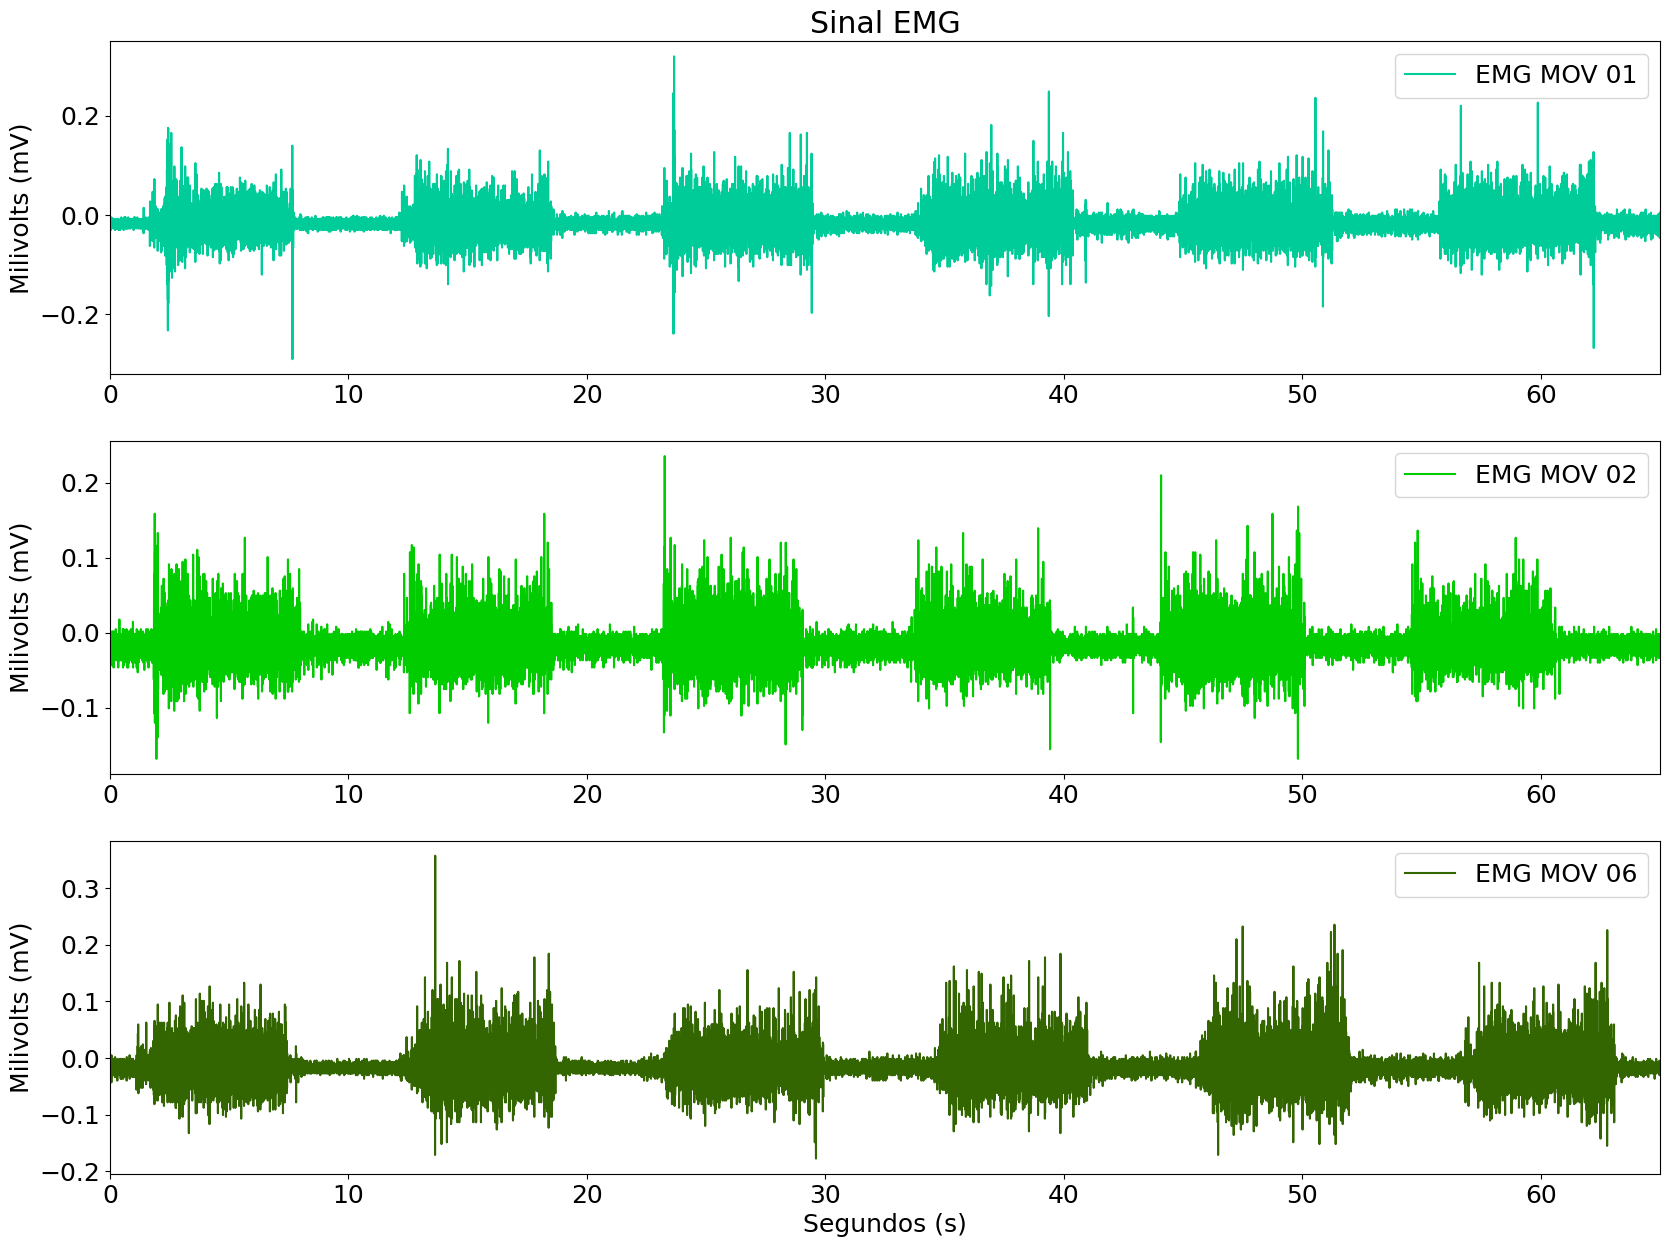

In [7]:
MOV_1 = np.loadtxt('exercicio_01_v6.txt')
MOV_2 = np.loadtxt('exercicio_02_v6.txt')
MOV_6 = np.loadtxt('exercicio_06_v6.txt')

emg1_mV = a * MOV_1 / b + c
emg2_mV = a * MOV_2 / b + c
emg6_mV = a * MOV_6 / b + c


figure(figsize=(20, 15), dpi=100)

t1 = np.linspace(INICIO, 65, len(emg1_mV[:,5]))
t2 = np.linspace(INICIO, 65, len(emg2_mV[:,5]))
t3 = np.linspace(INICIO, 65, len(emg6_mV[:,5]))

plt.rcParams['font.size'] = '18'

plt.subplot(311)
plt.title("Sinal EMG")
plt.xlim(INICIO, 65)
plt.ylabel("Milivolts (mV)")
plt.plot(t1, emg1_mV[:,5], '#00cc99', label="EMG MOV 01")
plt.legend()

plt.subplot(312)
plt.xlim(INICIO, 65)
plt.ylabel("Milivolts (mV)")
plt.plot(t2, emg2_mV[:,5], '#00cc00', label="EMG MOV 02")
plt.legend()

plt.subplot(313)
plt.xlim(INICIO, 65)
plt.ylabel("Milivolts (mV)")
plt.plot(t3, emg6_mV[:,5], '#336600', label="EMG MOV 06")
plt.legend()
plt.xlabel("Segundos (s)")

plt.show()

## 4.2 Envelopamento:

Após a normalização do sinal, obtém-se a janela correspondente a cada movimento. Da janela, são retirados parâmetros A finalidade do processo de envelopamento consiste em pegar o sinal filtrado pelo passa-banda e aplicar um filtro digital linear duas vezes (direta e reversa). Depois de filtrar os dados na direção direta, a função reverte a sequência filtrada e a executa de volta pelo filtro. O filtro combinado tem fase zero e uma ordem de filtro duas vezes maior do que o original.

In [8]:
taxa_amostragem = 1000 # definição da taxa de amostragem.
nyq = 0.5 * taxa_amostragem # definição da frequência de nyquist.
freq_critica_baixa = 300 / nyq # definição de baixa frequência crítica.
freq_critica_alta = 10 / nyq # definição de alta frequência crítica.

# Filtro passa-alta.
b, a = butter(2, freq_critica_alta, btype='high')
emg_ENVOLTORIA  = signal.filtfilt(b, a, emg_ENVOLTORIA)

# Filtro passa-baixa.
b1, a1 = butter(2, freq_critica_baixa, btype='low') # Filtro butterworth de 2a ordem.
emg_ENVOLTORIA  = signal.filtfilt(b1, a1, emg_ENVOLTORIA) # Filtros de fase zero (respostas de impulso uniformes)

# Retificação do sinal.
emg_ENVOLTORIA = np.abs(emg_ENVOLTORIA)

# Filtro passa-baixa. 
b3, a3 = signal.butter(2, 7/(taxa_amostragem/2), btype = 'low')

# Filtro filtfilt para 
rmss = signal.filtfilt(b3, a3, emg_ENVOLTORIA)

O resultado desta etapa consiste em deixar o sinal "acolchoado", evidenciando suas características.

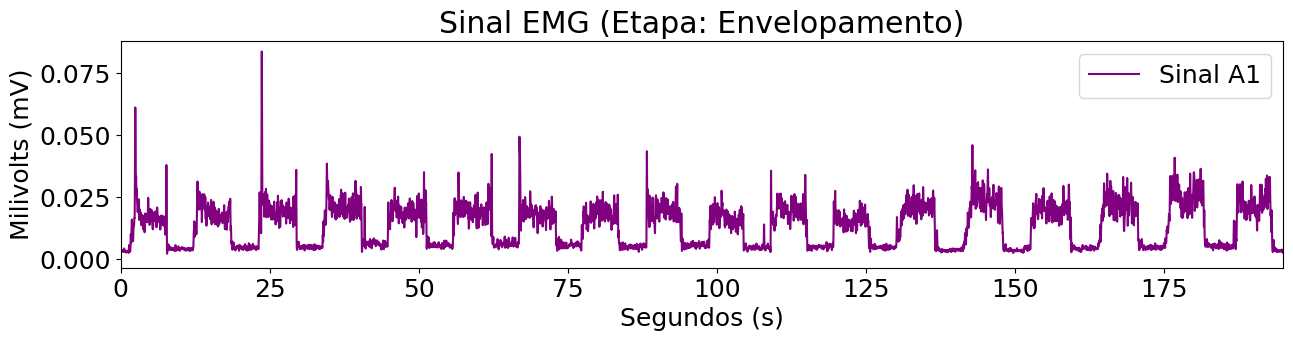

In [9]:
figure(figsize = (15, 3), dpi = 100)
t = np.linspace(INICIO, FIM, len(rmss))

plt.xlim(INICIO, FIM)
#plt.ylim(0, 0.4)
plt.plot(t, rmss, 'purple', label = 'Sinal A1')
plt.title("Sinal EMG (Etapa: Envelopamento)")
plt.xlabel("Segundos (s)")
plt.ylabel("Milivolts (mV)")
plt.legend()
plt.show() 

## 4.3 Operador de energia Teager–Kaiser (TKEO) :

O operador é baseado na definição de energia necessária para gerar um sinal.

Esse operador fornece uma estimativa da energia e amortecimento instantâneos em função da amplitude e da frequência instantâneas de um sinal monocromático ou unimodal.

O TKEO é sempre aplicado depois do sinal passar por um filtro passa-faixa.

A etapa TKEO tem como objetivo, condicionar o sinal envelopado para auxiliar na detecção do início e fim de atividade no sinal.

In [10]:
emg_TKEO = emg_TKEO - average(emg_TKEO)

# Definição de frequência para filtragem.
corte_baixa_freq = 10 # Hz
corte_alta_freq = 300 # Hz


# Aplicação do filtro no sinal.
emg_TKEO = bsnb.aux_functions._butter_bandpass_filter(emg_TKEO, corte_baixa_freq, corte_alta_freq, taxa_amostragem)

TKEO = []

for i in range(0, len(emg_TKEO)):
    
    if i == 0 or i == len(emg_TKEO) - 1:
        
        TKEO.append(emg_TKEO[i])
        
    else:
        
        TKEO.append(power(emg_TKEO[i], 2) - (emg_TKEO[i+1] * emg_TKEO[i-1]))

        
# Retificação do sinal.         
sinal_retificado = absolute(TKEO) # Calcula o valor absoluto do  elemento.
sinal_retificado = bsnb.aux_functions._moving_average(sinal_retificado, taxa_amostragem / 10) # Aplicação de filtro de média móvel para suavização do sinal.       

nivel_suavizacao_perc = 25 # Percentual de suavização.         
nivel_suavizacao = int((nivel_suavizacao_perc / 100) * taxa_amostragem)
sinal_suavizado = []

for i in range(0, len(sinal_retificado)):
    
    if nivel_suavizacao < i < len(sinal_retificado) - nivel_suavizacao:
        
        sinal_suavizado.append(mean(sinal_retificado[i - nivel_suavizacao:i + nivel_suavizacao]))
        
    else:
        
        sinal_suavizado.append(0)

media_sinal_pre_pro = average(emg_TKEO) # Calcula a média do sinal e atribui à uma variável.
desv_sinal_pre_pro = std(emg_TKEO) # Calcula o desvio padrão do sinal e atribui à uma variável.



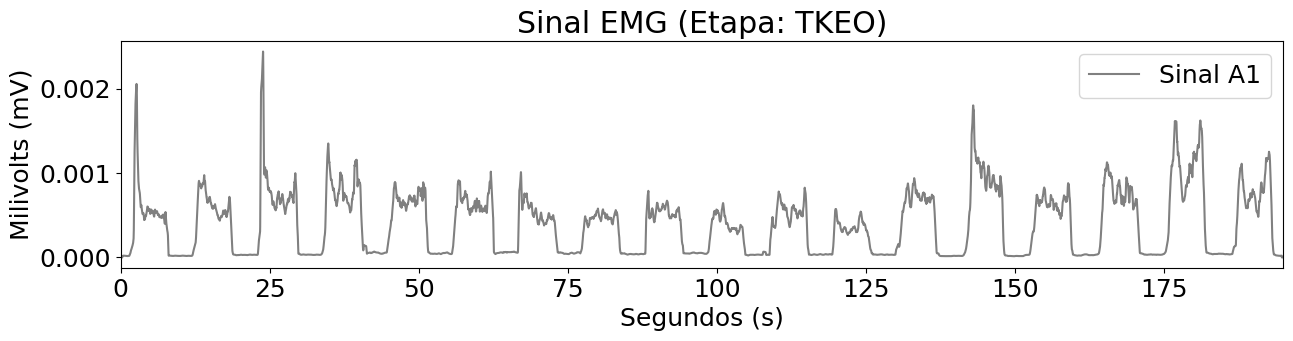

In [11]:
figure(figsize = (15, 3), dpi = 100)
t = np.linspace(INICIO, FIM, len(sinal_suavizado))

plt.xlim(INICIO, FIM)
#plt.ylim(0, 0.4)
plt.plot(t, sinal_suavizado, 'grey', label = 'Sinal A1')
plt.title("Sinal EMG (Etapa: TKEO)")
plt.xlabel("Segundos (s)")
plt.ylabel("Milivolts (mV)")
plt.legend()
plt.show() 

## 4.4 Regressão normal:

A principal vantagem da regressão, é evitar que valores muito discrepantes ou muito altos, influenciem em excesso os coeficientes de classificação.

A função desta etapa, consiste em calcular o resultado, da soma da interceptação da regressão linear, do sinal suavizado, com o produto da inclinação da regressão linear do sinal suavizado e o nível limite definido

In [12]:
# Definição de função de regressão.
def RegressaoNorm (nivel_limite_def):
    
    nivel_limite_perc_0 = (- media_sinal_pre_pro) / float(desv_sinal_pre_pro)
    nivel_limite_perc_100 = (max(sinal_suavizado) - media_sinal_pre_pro) / float(desv_sinal_pre_pro)
    inclinacao, interceptacao = linregress([0, 100], [nivel_limite_perc_0, nivel_limite_perc_100])[:2]
    return inclinacao * nivel_limite_def + interceptacao

nivel_limite = 10
nivel_limite_norm_10 = RegressaoNorm(nivel_limite)

limite_10 = media_sinal_pre_pro + nivel_limite_norm_10 * desv_sinal_pre_pro

## 4.5 Comparação:

Para saber o início e fim de ativação do movimento, esta etapa consiste em fazer uma comparação lógica.

Ela confere o valor suavizado, com um limite calculado, (que é o produto do desvio padrão do sinal com sua regressão normal), somado com o valor médio do sinal.

Se o valor do sinal suavizado for maior ou igual que o limite obtido, logo o sinal agrupado (resultado) terá valor igual à 1, se não será igual à 0 (zero).

In [13]:
sinal_agrupado = []

for i in range(0, len(emg_TKEO)):
    
    if sinal_suavizado[i] >= limite_10:
        
        sinal_agrupado.append(1)
        
    else:
        
        sinal_agrupado.append(0)
        
        
# Aplicação do sinal agrupado para roltulação.
sinal_rotulado = rotulo_sinal(sinal_agrupado)

# Aplicação do sinal agrupado para contagem de repetições.
sinal_repedido = repete_sinal(sinal_agrupado)

# 5. Apresentação dos sinais:

Esta etapa consiste em mostrar 5 gráficos obtidos pelo algoritmo e o sinal EMG:

a)	sinal EMG A1;

b)	envoltória;

c)	sinal identificado por início e fim de movimento;

d)	sinal rotulado;

e)	repetição.

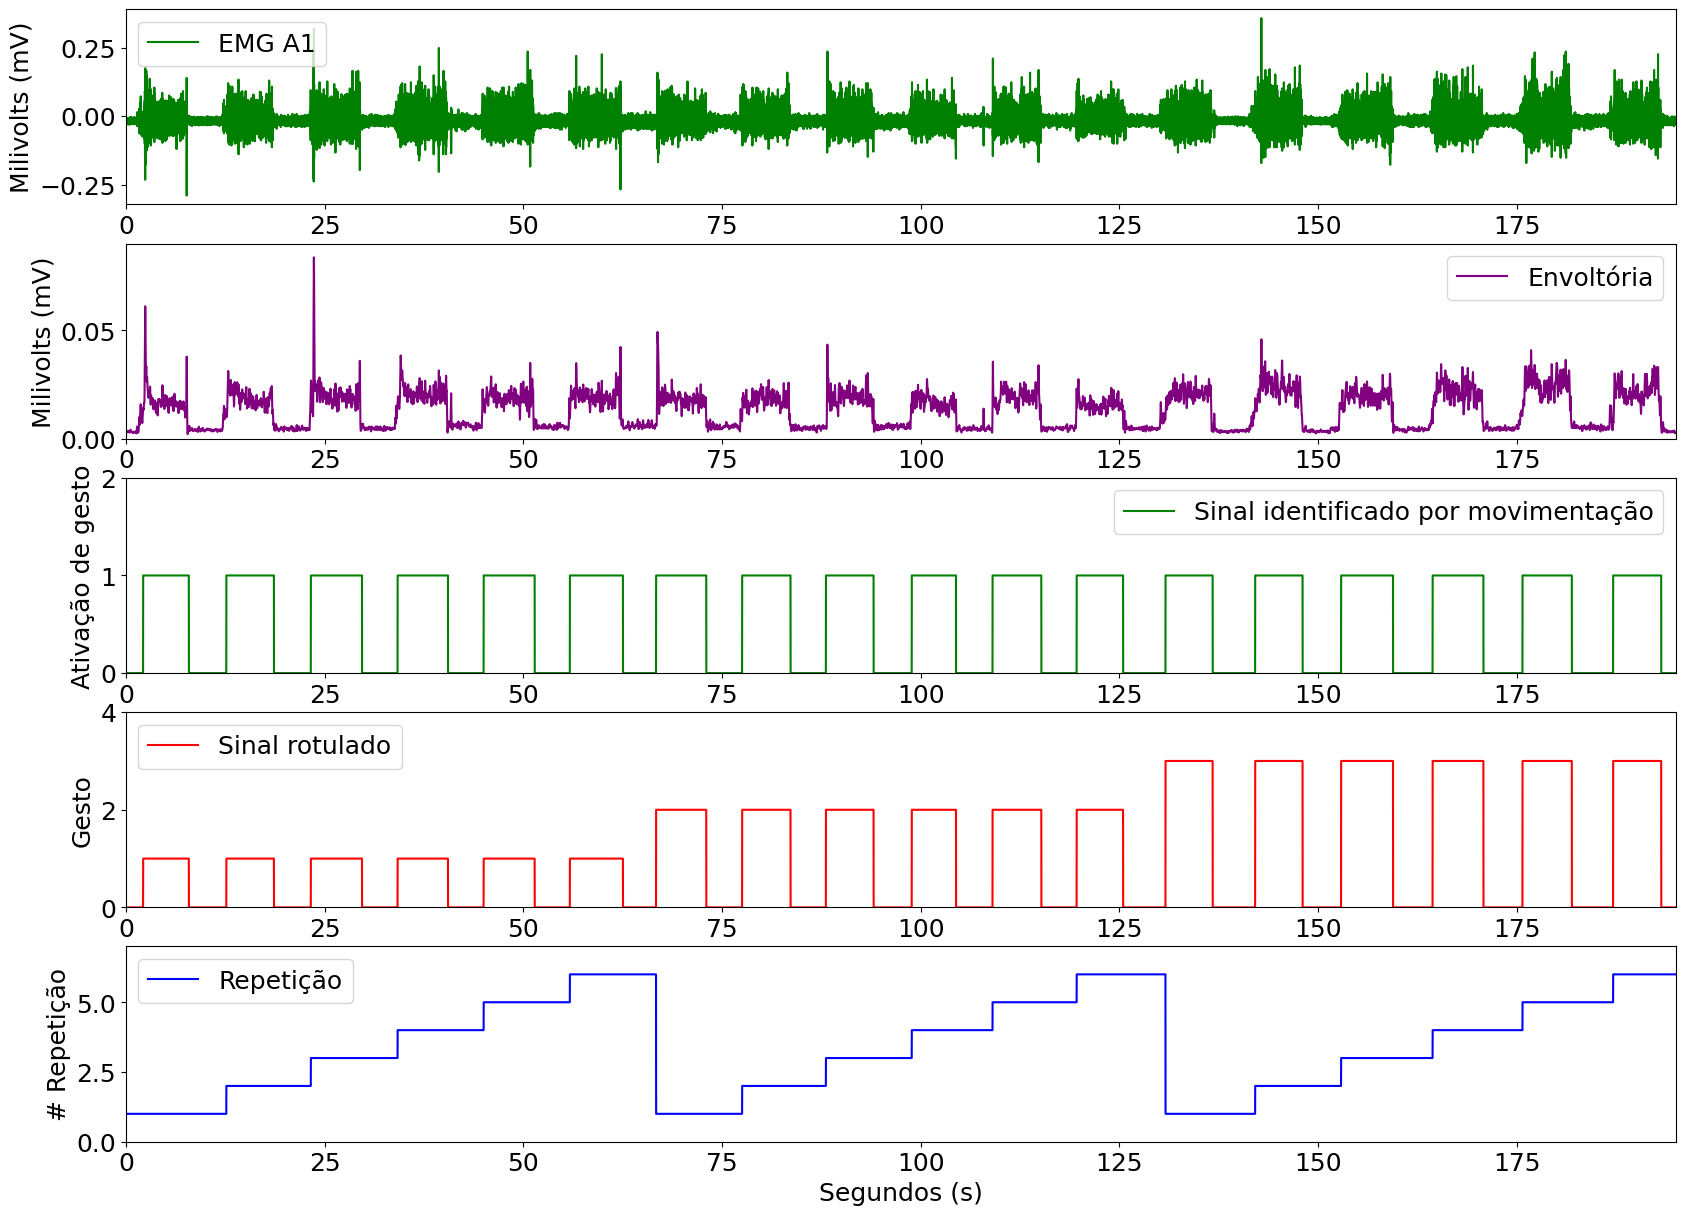

In [15]:
figure(figsize=(20, 15), dpi=100)

plt.subplot(511)
plt.xlim(INICIO, FIM)
#plt.ylim(0, 0.4)
plt.ylabel("Milivolts (mV)")
plt.plot(t, emg_mV[:,5], 'green', label="EMG A1")
plt.legend()

plt.subplot(512)
plt.xlim(INICIO, FIM)
plt.ylim(0, 0.09)
plt.ylabel("Milivolts (mV)")
plt.plot(t, rmss, 'purple', label="Envoltória")
plt.legend()

plt.subplot(513)
plt.xlim(INICIO, FIM)
plt.ylim(0, 2)
plt.ylabel("Ativação de gesto")
plt.plot(t, sinal_agrupado, 'green', label="Sinal identificado por movimentação")
plt.legend()

plt.subplot(514)
plt.xlim(INICIO, FIM)
plt.ylim(0, 4)
plt.ylabel("Gesto")
plt.plot(t, sinal_rotulado, 'red', label="Sinal rotulado")
plt.legend()

plt.subplot(515)
plt.xlim(INICIO, FIM)
plt.ylim(0, 7)
plt.xlabel("Segundos (s)")
plt.ylabel("# Repetição")
plt.plot(t, sinal_repedido, 'blue', label="Repetição")
plt.legend()
plt.show()

# 6. Exportação dos resultados:

É a parte final do algoritmo.

Esse processo trata de exportar em um arquivo de texto, os valores do Sinal Rotulado, Repetição e o Sinal EMG_A1.

Anexando também no início do arquivo, as informações sobre o Sujeito que foi adquirido o sinal, o dispositivo utilizado na aquisição, gestos realizados, rótulos, taxa de atualização (em hertz) e resolução (em bits).

In [16]:
# Cria e atribui em um dataframe, os resultados adquiridos anteriormente.
resultado = pd.DataFrame()
resultado['Exercicio'] = sinal_rotulado
resultado['Repeticao'] = sinal_repedido
resultado['EMG_A1'] = emg_ADC[:,5]
resultado

,Exercicio,Repeticao,EMG_A1
0,0,1,506.0
1,0,1,506.0
2,0,1,505.0
3,0,1,506.0
4,0,1,506.0
...,...,...,...
195145,0,6,506.0
195146,0,6,505.0
195147,0,6,506.0
195148,0,6,506.0


In [17]:
# Salva os valores do dataframe em um arquivo de texto.
np.savetxt('resultado.txt', resultado.values, fmt='%d')

# Anexa no arquivo, as informações de parâmetros de aquisição do sinal.
anexador_texto('resultado.txt', info)